In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pycaret.time_series import *
import warnings
warnings.filterwarnings('ignore')
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

In [28]:
# Load the data
spurs = pd.read_csv('..\\data\\spurs.csv')
spurs = spurs[(spurs['season_type']==0) & (spurs['season']<2021) & (spurs['season']>2000)].reset_index(drop=True)

## Econometrics

In [30]:
spurs=spurs[['score_diff']]
exp = TSForecastingExperiment()
exp.setup(data = spurs, target='score_diff' ,  fh = 16, coverage=0.90)

,Description,Value
0,session_id,3084
1,Target,score_diff
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(1531, 1)"
5,Transformed data shape,"(1531, 1)"
6,Transformed train set shape,"(1515, 1)"
7,Transformed test set shape,"(16, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


### Exploring relevant properties of data

In [31]:
exp.check_stats(test='adf')

,Test,Test Name,Data,Property,Setting,Value
0,Stationarity,ADF,Transformed,Stationarity,{'alpha': 0.05},True
1,Stationarity,ADF,Transformed,p-value,{'alpha': 0.05},0.001804
2,Stationarity,ADF,Transformed,Test Statistic,{'alpha': 0.05},-3.933201
3,Stationarity,ADF,Transformed,Critical Value 1%,{'alpha': 0.05},-3.434694
4,Stationarity,ADF,Transformed,Critical Value 5%,{'alpha': 0.05},-2.863459
5,Stationarity,ADF,Transformed,Critical Value 10%,{'alpha': 0.05},-2.567791


In [19]:
exp.plot_model(plot="diff", data_kwargs={"order_list": [1], "acf": True, "pacf": True})

### Trying most common econometric models

In [32]:
auto_arima = exp.create_model('auto_arima', cross_validation=False)
auto_ets = exp.create_model('ets', cross_validation=False)
arima111 = exp.create_model('arima', order = (1,1,1),  with_intercept=True, cross_validation=False) 

,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,0.6838,0.6229,0.0732,0.0847,0.8973,1.3397,-0.1987


,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,0.6630,0.6068,0.0710,0.0825,0.8798,1.2374,-0.1375


,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,0.8589,0.8501,0.0919,0.1156,1.3623,1.3962,-1.2329


In [7]:
exp.compare_models(include=[arima111, auto_arima, auto_ets], cross_validation=False)

AutoETS(seasonal='mul', sp=7, trend='add')

In [8]:
exp.plot_model([ auto_ets], plot='forecast', data_kwargs={'fh':16, 'labels':["Auto ETS"]})

In [9]:
exp.plot_model([ auto_arima], plot='forecast', data_kwargs={'fh':16, 'labels':["Auto ETS"]})

## Machine Learning

In [21]:
spurs['Lag1'] = spurs['score_diff'].shift(1)
spurs['Lag2'] = spurs['score_diff'].shift(2)
spurs['Lag3'] = spurs['score_diff'].shift(3)
spurs = spurs.dropna()


X = spurs[['Lag1', 'Lag2', 'Lag3']]
y = spurs['score_diff']

# Split the data
test_range=16


X_train, X_test = X[:-test_range], X[-test_range:]
y_train, y_test = y[:-test_range], y[-test_range:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1240, 3), (16, 3), (1240,), (16,))

In [22]:
def forecast_future(model, data, steps=test_range):

    future_forecasts = np.empty(steps)

    lag1=data['Lag1'].iloc[-1]
    lag2=data['Lag2'].iloc[-1]
    lag3=data['Lag3'].iloc[-1]

    for i in range(steps):
        forecast = model.predict([[lag1, lag2, lag3]])[0]
        future_forecasts[i]=(forecast)

        lag3=lag2
        lag2=lag1
        lag1=forecast
    
    return future_forecasts



In [23]:
dt_model = DecisionTreeRegressor(max_depth=10)
dt_model.fit(X_train, y_train)

y_pred = dt_model.predict(X_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred)
mape_train

1.4916952894940836

In [24]:
y_test_pred = forecast_future(dt_model, spurs)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
mape_test

1.8499483212293568

In [27]:
mae=mean_absolute_error(y_test, y_test_pred)
mae

0.11060673144590755

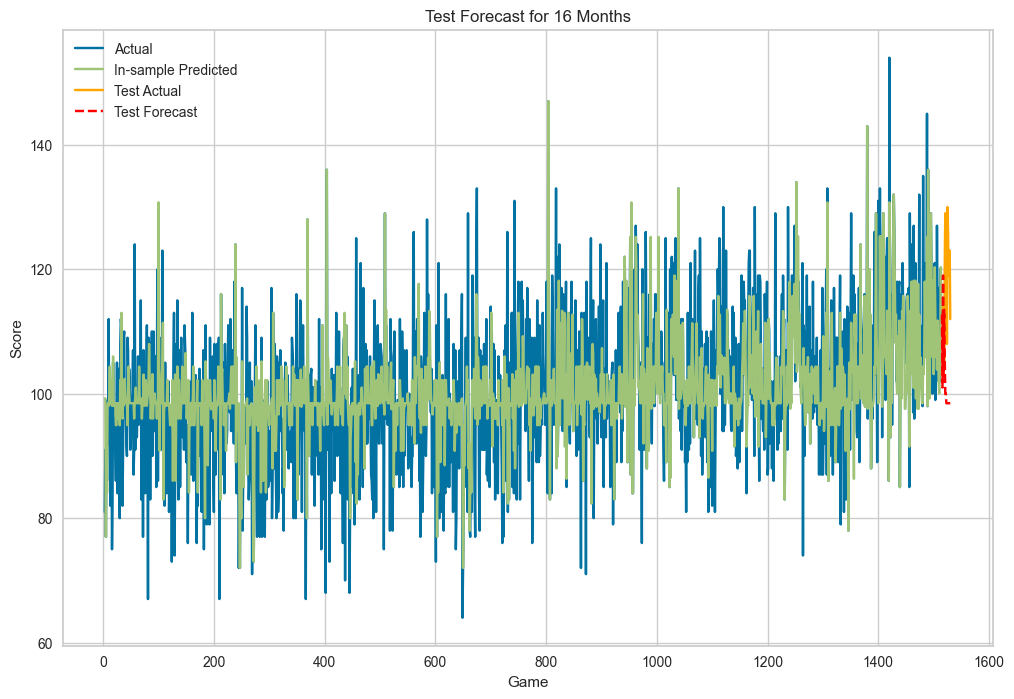

In [27]:
plt.figure(figsize=(12, 8))
plt.title('Spurs Game Scores')
plt.xlabel('Game')
plt.ylabel('Score')
plt.plot(y_train.index, y_train, label='Actual')
plt.plot(y_train.index, y_pred, label='In-sample Predicted')
plt.plot(y_test.index, y_test, label='Test Actual',  color='orange')
plt.plot(y_test.index, y_test_pred, label='Test Forecast', linestyle='--', color='red')   
plt.title(f'Test Forecast for {test_range} Months')
plt.legend()
plt.show()

## PyCaret horse race of all models

In [28]:
exp = TSForecastingExperiment()
exp = setup(data = spurs, target = 'score', fh = 16, session_id=1000)
exp.compare_models(cross_validation=False, sort='rmse')

,Description,Value
0,session_id,1000
1,Target,score
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(1528, 4)"
5,Transformed data shape,"(1528, 4)"
6,Transformed train set shape,"(1512, 4)"
7,Transformed test set shape,"(16, 4)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
naive,Naive Forecaster,0.7189,0.6560,8.6250,9.9499,0.0724,0.0742,-0.1928,0.0100
croston,Croston,0.7276,0.6675,8.7296,10.1253,0.0731,0.0751,-0.2352,0.0100
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,0.8213,0.7744,9.8535,11.7459,0.0812,0.0852,-0.6622,0.0800
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,0.8275,0.7827,9.9283,11.8731,0.0817,0.0859,-0.6985,0.1100
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,0.8292,0.7831,9.9484,11.8788,0.0819,0.0861,-0.7001,0.0700
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,0.8302,0.7841,9.9600,11.8941,0.0820,0.0862,-0.7044,0.0700
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,0.8302,0.7841,9.9600,11.8941,0.0820,0.0862,-0.7044,0.0800
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,0.8300,0.7848,9.9576,11.9045,0.0819,0.0861,-0.7074,0.0800
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,0.8300,0.7848,9.9578,11.9046,0.0820,0.0861,-0.7075,0.0800
gbr_cds_dt,Gradient Boosting w/ Cond. Deseasonalize & Detrending,0.8260,0.7864,9.9097,11.9284,0.0815,0.0857,-0.7143,0.5300


NaiveForecaster()

## Normalizing scores by defensive strength of opponent

### Setting up data

In [2]:
# Load the data
spurs = pd.read_csv('..\\data\\spurs.csv')
spurs = spurs[(spurs['season_type']==0) & (spurs['season']<2021) & (spurs['season']>2000)].reset_index(drop=True)
spurs=spurs[['score_diff']]

In [3]:
spurs['Lag1'] = spurs['score_diff'].shift(1)
spurs['Lag2'] = spurs['score_diff'].shift(2)
spurs['Lag3'] = spurs['score_diff'].shift(3)
spurs = spurs.dropna()


X = spurs[['Lag1', 'Lag2', 'Lag3']]
y = spurs['score_diff']

# Split the data
test_range=16


X_train, X_test = X[:-test_range], X[-test_range:]
y_train, y_test = y[:-test_range], y[-test_range:]

In [6]:
exp = TSForecastingExperiment()
exp = setup(data = spurs, target = 'score_diff', fh = 16, session_id=1000)
exp.check_stats(test='adf')

,Description,Value
0,session_id,1000
1,Target,score_diff
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(1528, 4)"
5,Transformed data shape,"(1528, 4)"
6,Transformed train set shape,"(1512, 4)"
7,Transformed test set shape,"(16, 4)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


,Test,Test Name,Data,Property,Setting,Value
0,Stationarity,ADF,Transformed,Stationarity,{'alpha': 0.05},True
1,Stationarity,ADF,Transformed,p-value,{'alpha': 0.05},0.001818
2,Stationarity,ADF,Transformed,Test Statistic,{'alpha': 0.05},-3.931091
3,Stationarity,ADF,Transformed,Critical Value 1%,{'alpha': 0.05},-3.434702
4,Stationarity,ADF,Transformed,Critical Value 5%,{'alpha': 0.05},-2.863462
5,Stationarity,ADF,Transformed,Critical Value 10%,{'alpha': 0.05},-2.567793


### Finding best models

In [7]:
exp.compare_models(include=['naive', 'auto_arima', 'dt_cds_dt','rf_cds_dt', 'et_cds_dt', 'gbr_cds_dt', 'ada_cds_dt', 'lightgbm_cds_dt', 'catboost_cds_dt'],cross_validation=False, sort='mae')

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
naive,Naive Forecaster,0.6596,0.6068,0.0706,0.0825,0.8796,1.2007,-0.1379,0.0100
gbr_cds_dt,Gradient Boosting w/ Cond. Deseasonalize & Detrending,0.7260,0.6747,0.0777,0.0917,1.0384,1.5483,-0.4064,0.6900
ada_cds_dt,AdaBoost w/ Cond. Deseasonalize & Detrending,0.8135,0.7493,0.0870,0.1019,1.0136,1.7627,-0.7346,0.2600
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,0.8344,0.7555,0.0893,0.1027,1.1705,1.7363,-0.7637,0.4300
et_cds_dt,Extra Trees w/ Cond. Deseasonalize & Detrending,0.8551,0.7868,0.0915,0.1070,1.1463,1.6460,-0.9130,0.2600
catboost_cds_dt,CatBoost Regressor w/ Cond. Deseasonalize & Detrending,0.8622,0.8196,0.0922,0.1115,1.2135,1.6017,-1.0758,2.2400
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,0.9020,0.8102,0.0965,0.1102,1.3766,1.6796,-1.0285,0.1500
auto_arima,Auto ARIMA,1.0117,0.9025,0.1082,0.1227,1.5230,1.6994,-1.5169,74.9900
dt_cds_dt,Decision Tree w/ Cond. Deseasonalize & Detrending,1.0292,0.9519,0.1101,0.1294,1.8003,1.1839,-1.7998,0.0900


Processing:   0%|          | 0/41 [00:00<?, ?it/s]

NaiveForecaster()

### Further exploration of top performing ML and econometric models

In [16]:
naive = exp.create_model('naive', cross_validation=False)
y_pred = exp.predict_model(naive, fh=16)

,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,0.6596,0.6068,0.0706,0.0825,0.8796,1.2007,-0.1379


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,Naive Forecaster,0.6596,0.6068,0.0706,0.0825,0.8796,1.2007,-0.1379


In [17]:
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
mape_test

1.5230283078991094

In [8]:
auto_arima = exp.create_model('auto_arima', cross_validation=False)


y_test_pred = exp.predict_model(auto_arima, fh=test_range)

mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
mape_test

,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,1.0117,0.9025,0.1082,0.1227,1.5230,1.6994,-1.5169


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,Auto ARIMA,1.0117,0.9025,0.1082,0.1227,1.5230,1.6994,-1.5169


1.5230283078991094

In [ ]:
auto_arima.fit(X_train, y_train)
y_pred = auto_arima.predict(y_test.index, X_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred)
mape_test

In [9]:
gbr = exp.create_model('gbr_cds_dt', cross_validation=False)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,12:38:51
Status,. . . . . . . . . . . . . . . . . .,Selecting Estimator
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,0.7260,0.6747,0.0777,0.0917,1.0384,1.5483,-0.4064


In [13]:
yp = exp.predict_model(gbr, fh=test_range)
mape_test = mean_absolute_percentage_error(y_test, yp)
mape_test

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,GradientBoostingRegressor,0.7260,0.6747,0.0777,0.0917,1.0384,1.5483,-0.4064


1.0383633707369677

In [11]:
gbr.fit(y_train, X_train)
y_pred = gbr.predict(y_test.index,X_test)


In [12]:
mape_test = mean_absolute_percentage_error(y_test, y_pred)
mape_test

1.4220556675225973